In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The goal of this project is to build a GAN that generates 7000 Monet style images. To train our GAN, we are given 300 input Monet images, as well as 7000 random photos. The plan for this project is to use a cycleGAN, which allows for unpaired image to image translation using conditional GANs. It will capture to characteristics of the Monet images, and figure out how these characteristics can be translated into anohther set of images.

My workflow was inspired by the Tensorflow tutorial on CycleGAN -
https://www.tensorflow.org/tutorials/generative/cyclegan

The tutorial utilized a generator and discriminator from a cGAN from the pix2pix tutorial (https://www.tensorflow.org/tutorials/generative/pix2pix). I install the tensorflow_examples package that enables importing the generator and discriminator below

In [5]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-iuoux212
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-iuoux212
  Resolved https://github.com/tensorflow/examples.git to commit 29119b82008668ef7b86accea64f07f8915421a5
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1697250458.234461280913877459770598239055499887507454304677-py3-none-any.whl size=301569 sha256=5c5e52c62cb22fcddca779598964a50475a6e849c9c0f36ae9120ea4153ffab1
  Stored in directory: /tmp/pip-ephem-wheel-cache-y_chzd3m/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import os
import PIL
import keras
from keras import layers
from keras.callbacks import EarlyStopping

from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
from IPython.display import clear_output

from kaggle_datasets import KaggleDatasets

AUTOTUNE = tf.data.experimental.AUTOTUNE

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ModuleNotFoundError: No module named 'tensorflow_examples'

Loading the filesnames of our two images domains (Monet, non-Monet (photos))

In [7]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


Mehtods to load the images. To optimize my model, after my first attempt I added random jitter and mirroring to the Monet images to try and avoid overfitting. Jittering resizes the images to 286 x 286 and then randomly crops them back to 256 x 256. Mirroring randomly flips the images horizontally. Table at the end of the notebook will display the results.

In [8]:
IMAGE_SIZE = [256, 256]

def normalize(image):
    return (tf.cast(image, tf.float32) / 127.5) - 1

def decode_image(image):
    #image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.reshape(image, [256, 256, 3])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[256, 256, 3])
    return cropped_image

def random_jitter(image):
    # resizing to 286 x 286 x 3 
    image = tf.image.resize(image, [int(256*1.3), int(256*1.3)],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)
    # random mirroring
    image = tf.image.random_flip_left_right(image)
    return image

def preprocess_image_train(image, label=None):
    image = random_jitter(image)
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=False, ordered=False, repeats=10):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.concatenate(dataset.map(random_jitter, num_parallel_calls=AUTOTUNE).shuffle(100000, reshuffle_each_iteration=True).repeat(repeats))
    dataset = dataset.map(normalize, num_parallel_calls=AUTOTUNE).shuffle(100000)
    return dataset

def load_photos(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(normalize, num_parallel_calls=AUTOTUNE).shuffle(1000)
    return dataset

In [9]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_photos(PHOTO_FILENAMES, labeled=True).batch(1)

In [10]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Displaying the first image from each image domain

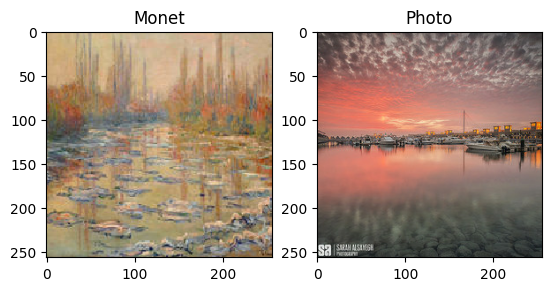

In [11]:
plt.subplot(121)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

Importing and using the Pix2Pix generator and discriminator. There are two generators (G and F) and two discriminators (X and Y) being trained. Generator G learns to transform image X to image Y, Generator F learns to transform image Y to image X. Discriminator X learns to differentiate between image X and genearted image X (F(Y)), Discriminator Y learns to differentiate between image Y and genearted image Y (G(X)).

In [12]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Testing the untrained generators

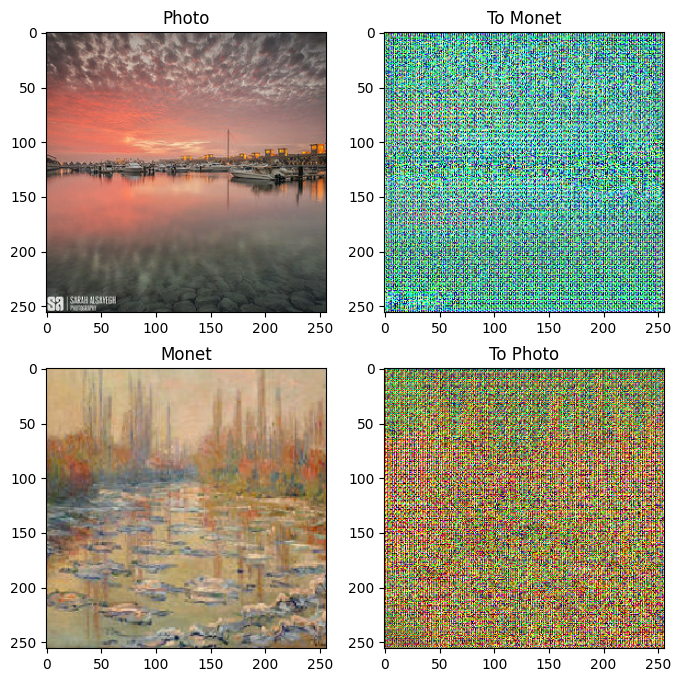

In [13]:
to_monet = generator_g(example_photo)
to_photo = generator_f(example_monet)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [example_photo, to_monet, example_monet, to_photo]
title = ['Photo', 'To Monet', 'Monet', 'To Photo']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

Testing the untrained discriminators

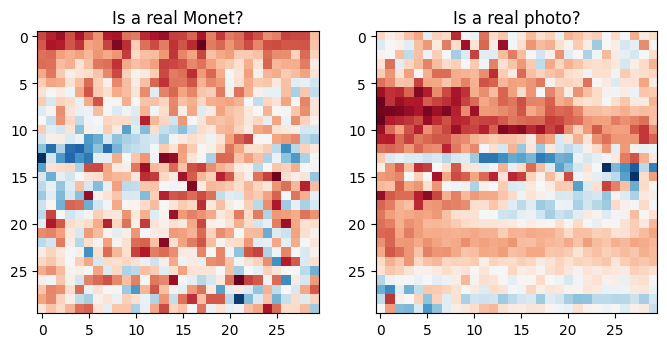

In [14]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real Monet?')
plt.imshow(discriminator_y(example_monet)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real photo?')
plt.imshow(discriminator_x(example_photo)[0, ..., -1], cmap='RdBu_r')

plt.show()

Defining the loss functions. The generator loss is a sigmoid cross-entropy loss of genearted images and an array of ones. The discriminator loss takes two inputs, a real image and generated image. real_loss is a sigmoid cross-entropy loss of the real images and an array of ones since they are all real images. generated_loss is a sigmoid cross-entropy loss of the generated images and an array of zeros since these are all fake images. The total_loss is the sum of real_loss and generated_loss.

In [15]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [17]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. So X pass through G yields Yhat. Yhat passed through F yields Xhat. MSE error is calculated between X and Xhat.

In [18]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [19]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and discriminators

In [20]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

# # Training

Would like to run more EPOCHS, but to reduce time training takes, using 3. Training loops first gets predictions, then calculates the loss, then calculates the gradients using backprop. Then applies the gradients to the optimizer.

In [22]:
EPOCHS = 3

In [23]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [24]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

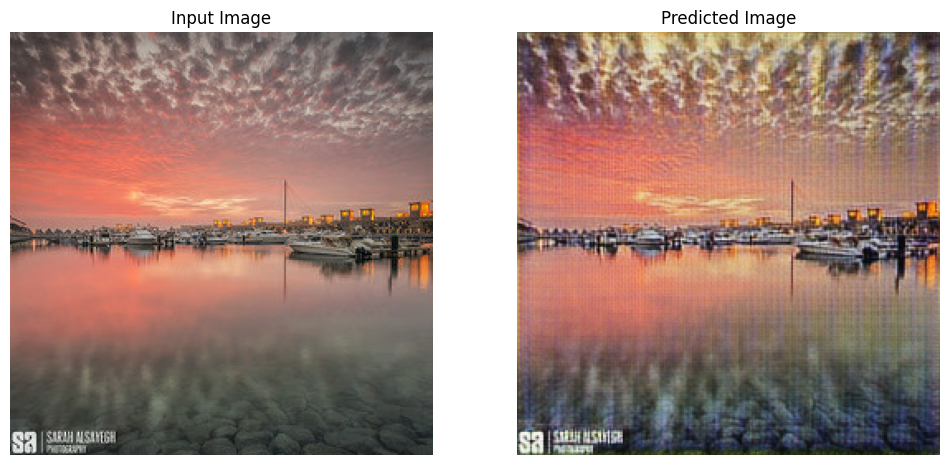

Time taken for epoch 1 is 920.6268932819366 sec



In [25]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((photo_ds, monet_ds)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (example_photo) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, example_photo)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

Displaying 5 photos with their Monet-esque counterparts

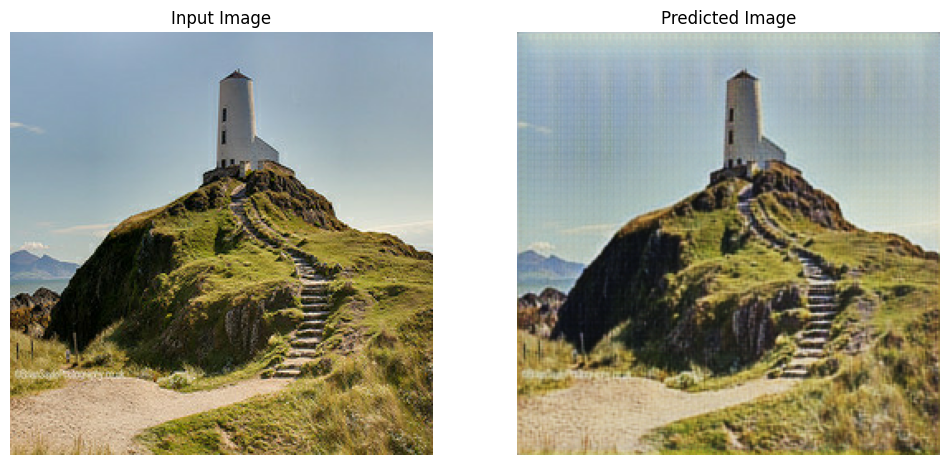

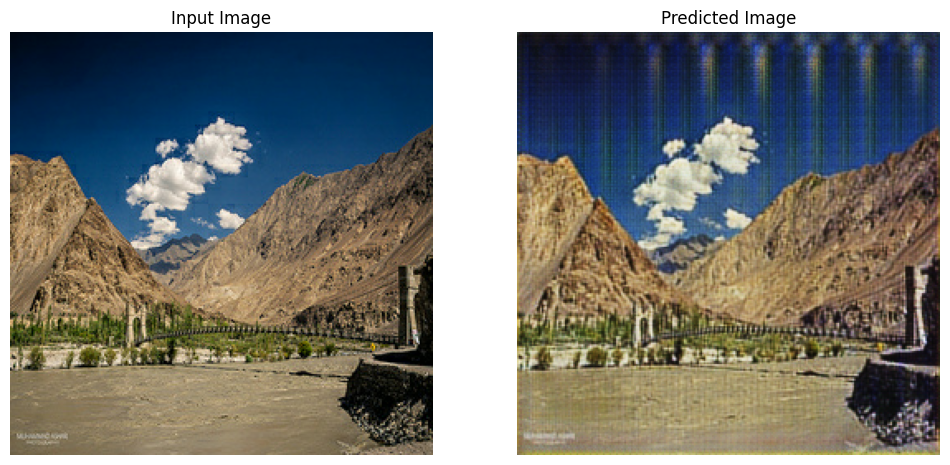

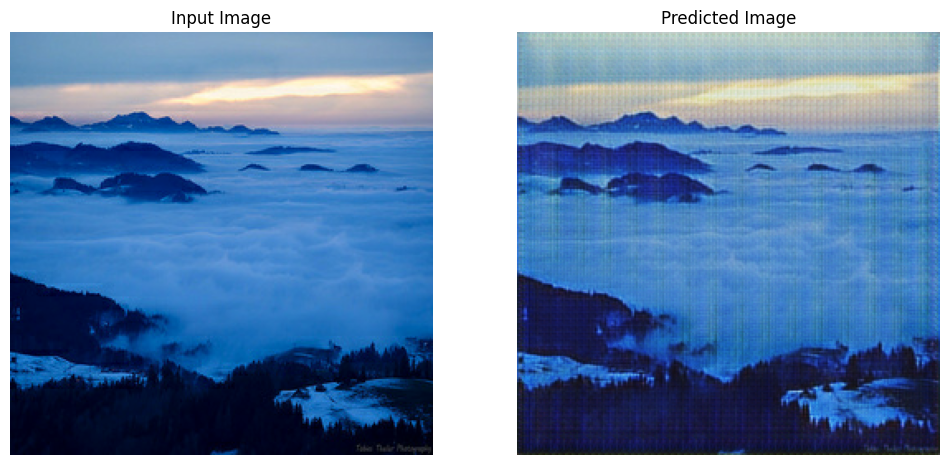

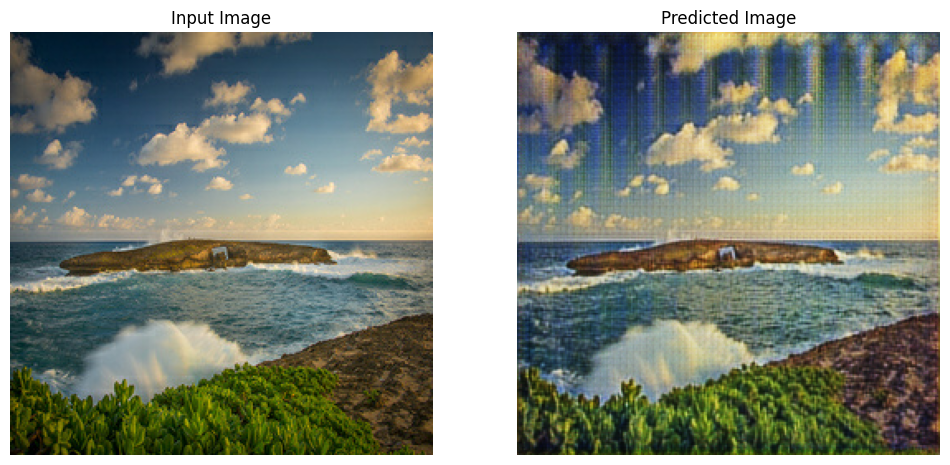

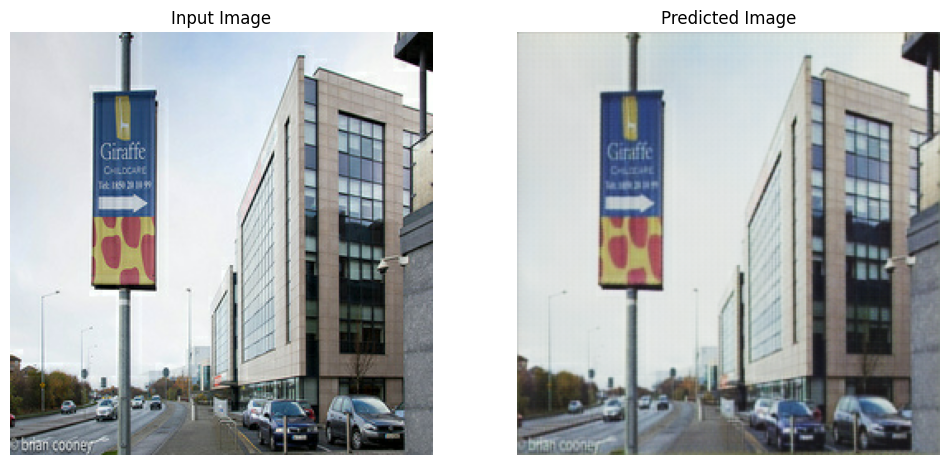

In [26]:
for inp in photo_ds.take(5):
    generate_images(generator_g, inp)

Creating submission file of 7250 photos with Monet style added

In [27]:
! mkdir /kaggle/working/images

mkdir: cannot create directory ‘/kaggle/working/images’: File exists


In [28]:
def generate_submission(model, test_input):
  prediction = model(test_input)
  prediction = prediction.numpy()
  prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
  prediction = prediction.reshape([256, 256, 3])
  return prediction

In [ ]:
i = 0
for inp in photo_ds.take(7250):
    prediction = generate_submission(generator_g, inp)
    im = PIL.Image.fromarray(prediction)
    im.save(f"/kaggle/working/images/{i}.jpg")
    i = i + 1

In [4]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working/images")

'/kaggle/working/images3.zip'

In [5]:
results = pd.DataFrame([['baseline', 74.12],['Jitter/Mirroring', 63.50]], columns=['model', 'score'])
results.sort_values('score')

model  score
1  Jitter/Mirroring  63.50
0          baseline  74.12

Adding jittering and mirroring to my Monet images greatly enhanced my GAN. Lower score is better in the competition. This is likely because we had so few images to begin with (300 Monet images) so creating additional images to train the model off of help reduce over fitting. 

Other things that could be done to improve the model include running many more epochs. I only ran three due to time constraints, which is definitely not enough. I wanted to run 10, but after starting the training process I realized that if I ran that many, and wasn't satisfied with the model or wanted to try and optimize it, the time needed to train that many epochs would just be too much for this assignment. Ideally I would run 50. I would also be interesting in just running a DCGAN vs the CycleGAN.

My github is here: https://github.com/crops004/DTSA-5511-wk5